In [1]:
!nvidia-smi

Fri Aug 16 13:12:38 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 556.12                 Driver Version: 556.12         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce GTX 1080      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   50C    P8             18W /  270W |    1899MiB /   8192MiB |      7%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# install tensorflow 2.15 since voxelmorph is not compatible with current build
import tensorflow as tf

if not tf.__version__.startswith('2.15'):
    !pip uninstall -y tensorflow
    !pip install tensorflow==2.15
# install voxelmorph
!pip install voxelmorph


[notice] A new release of pip available: 22.3.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import voxelmorph as vxm
import neurite as ne

import os
import urllib.request
import zipfile
import json
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib import colors, patches
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [4]:
# download dataset
filename = 'AbdomenCTCT.zip'
if not os.path.exists(filename):
    url = 'https://cloud.imi.uni-luebeck.de/s/32WaSRaTnFk2JeT/download/AbdomenCTCT.zip'
    urllib.request.urlretrieve(url, filename)

    # extract files
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('./')

In [5]:
def load_data(jsonData, dataFolderPath, training_or_test, filterString='0001'):
    images = []
    labels = []
    for sample in jsonData[training_or_test]:
        image = nib.load(dataFolderPath + sample['image'].removeprefix('.').replace(".csv", ".nii.gz")).get_fdata()
        images.append(image)
        if training_or_test == 'training':
            label = nib.load(dataFolderPath + sample['label'].removeprefix('.').replace(".csv", ".nii.gz")).get_fdata()
            labels.append(label)

    return np.array(images), np.array(labels)

In [6]:
# load data
with open('./AbdomenCTCT/AbdomenCTCT_dataset.json', 'r') as file:
    data_json = json.load(file)
dataFolder = './AbdomenCTCT'
images_raw, labels_raw = load_data(data_json, dataFolder, 'training')

In [7]:
images_raw.shape

(30, 192, 160, 256)

In [8]:
labels_raw.shape

(30, 192, 160, 256)

# Preprocess data

In [9]:
# normalize images
images_normalized = (images_raw - np.min(images_raw)) / (np.max(images_raw) - np.min(images_raw))

# rotate tensor
images_rotated = np.array([np.rot90(image, k=1, axes=(0, 2)) for image in images_normalized])
labels_rotated = np.array([np.rot90(image, k=1, axes=(0, 2)) for image in labels_raw])

# swap and flip axes
images = np.swapaxes(images_rotated, 1, 2)[:, ::-1, :, :]
labels = np.swapaxes(labels_rotated, 1, 2)[:, ::-1, :, :]

In [10]:
del images_raw
del labels_raw
del images_normalized
del images_rotated
del labels_rotated

(-0.5, 191.5, 255.5, -0.5)

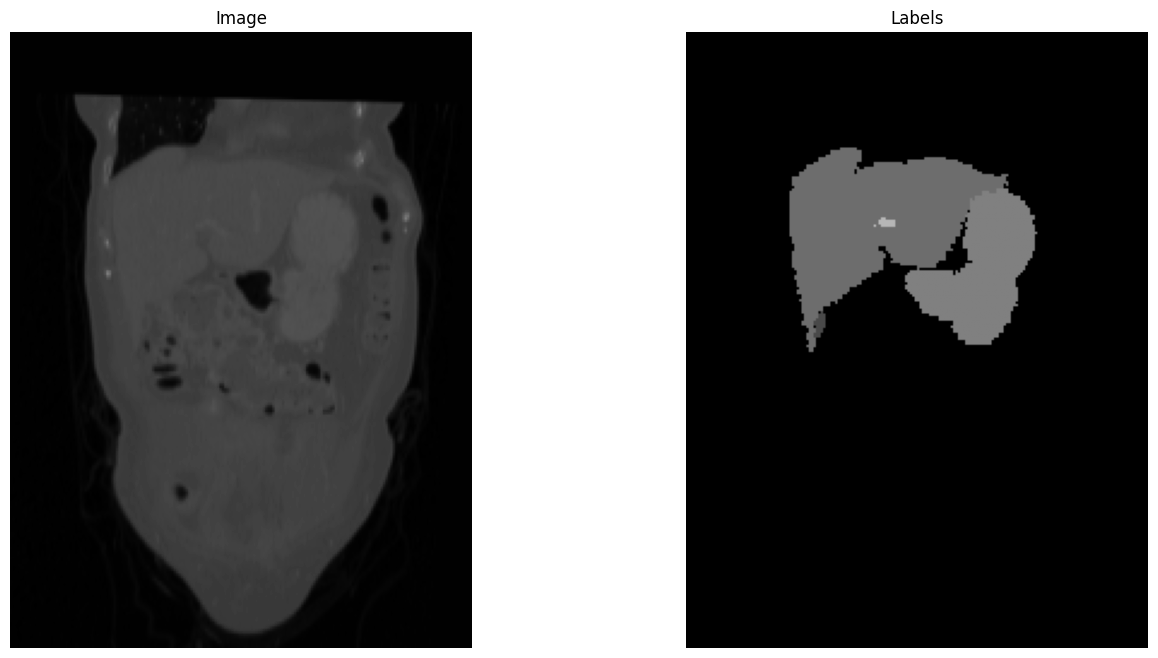

In [11]:
# preview data
img = 0
depth = 40

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 8))
ax0.imshow(images[img, depth], cmap='gray', vmin=0, vmax=1)
ax0.set_title("Image")
ax0.axis("off")
ax1.imshow(labels[img, depth], cmap='gray', vmin=0, vmax=14)
ax1.set_title("Labels")
ax1.axis("off")

In [12]:
# split dataset
_, test_images = train_test_split(images, test_size=0.2, random_state=10)
_, test_labels = train_test_split(labels, test_size=0.2, random_state=10)

In [13]:
del images
del labels
del _

In [14]:
test_images.shape

(6, 160, 256, 192)

# Define Model

In [15]:
legend_labels = {
    1: "spleen",
    2: "right kidney",
    3: "left kidney",
    4: "gall bladder",
    5: "esophagus",
    6: "liver",
    7: "stomach",
    8: "aorta",
    9: "inferior vena cava",
    10: "portal and splenic vein",
    11: "pancreas",
    12: "left adrenal gland",
    13: "right adrenal gland"
}

# define the input shapes
inshape = test_images.shape[1:]
nb_features = (
    (16, 32, 32),  # encoder-channels
    (32, 32, 16, 16)  # decoder-channels
)

# build model using VxmDense
spleen_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
spleen_model.load_weights('models/AbdomenCTCT_' + legend_labels[1] + '_model.h5')
rkidney_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
rkidney_model.load_weights('models/AbdomenCTCT_' + legend_labels[2] + '_model.h5')
lkidney_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
lkidney_model.load_weights('models/AbdomenCTCT_' + legend_labels[3] + '_model.h5')
gbladder_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
gbladder_model.load_weights('models/AbdomenCTCT_' + legend_labels[4] + '_model.h5')
esophagus_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
esophagus_model.load_weights('models/AbdomenCTCT_' + legend_labels[5] + '_model.h5')
liver_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
liver_model.load_weights('models/AbdomenCTCT_' + legend_labels[6] + '_model.h5')
stomach_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
stomach_model.load_weights('models/AbdomenCTCT_' + legend_labels[7] + '_model.h5')
aorta_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
aorta_model.load_weights('models/AbdomenCTCT_' + legend_labels[8] + '_model.h5')
ivc_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
ivc_model.load_weights('models/AbdomenCTCT_' + legend_labels[9] + '_model.h5')
pandsvein_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
pandsvein_model.load_weights('models/AbdomenCTCT_' + legend_labels[10] + '_model.h5')
pancreas_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
pancreas_model.load_weights('models/AbdomenCTCT_' + legend_labels[11] + '_model.h5')
ladrenalgland_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
ladrenalgland_model.load_weights('models/AbdomenCTCT_' + legend_labels[12] + '_model.h5')
radrenalgland_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
radrenalgland_model.load_weights('models/AbdomenCTCT_' + legend_labels[13] + '_model.h5')

# Test registration

In [16]:
# define a data generator
def test_data_generator(images, labels):
    while True:
        idx1 = np.random.randint(0, images.shape[0], size=1)
        idx2 = np.random.randint(0, images.shape[0], size=1)
        while idx2 == idx1:
            idx2 = np.random.randint(0, images.shape[0], size=1)

        fixed_image = images[idx1, ..., np.newaxis]
        fixed_labels = labels[idx1, ..., np.newaxis]

        moving_image = images[idx2, ..., np.newaxis]
        moving_labels = labels[idx2, ..., np.newaxis]

        yield fixed_image, fixed_labels, moving_image, moving_labels

In [17]:
# define validation generator
test_generator = test_data_generator(test_images, test_labels)

In [18]:
# get test sample
test_input = next(test_generator)

In [19]:
test_input[1].shape

(1, 160, 256, 192, 1)

In [20]:
each_org_transformation = []

for organ in tqdm(legend_labels):
    fixed_input = np.zeros_like(test_input[0])
    fixed_input[test_input[1] == organ] = test_input[0][test_input[1] == organ]
    moving_input = np.zeros_like(test_input[2])
    moving_input[test_input[3] == organ] = test_input[2][test_input[3] == organ]
    
    if organ == 1:
        test_pred = tuple(spleen_model.predict((fixed_input, moving_input)))
    elif organ == 2:
        test_pred = tuple(rkidney_model.predict((fixed_input, moving_input)))
    elif organ == 3:
        test_pred = tuple(lkidney_model.predict((fixed_input, moving_input)))
    elif organ == 4:
        test_pred = tuple(gbladder_model.predict((fixed_input, moving_input)))
    elif organ == 5:
        test_pred = tuple(esophagus_model.predict((fixed_input, moving_input)))
    elif organ == 6:
        test_pred = tuple(liver_model.predict((fixed_input, moving_input)))
    elif organ == 7:
        test_pred = tuple(stomach_model.predict((fixed_input, moving_input)))
    elif organ == 8:
        test_pred = tuple(aorta_model.predict((fixed_input, moving_input)))
    elif organ == 9:
        test_pred = tuple(ivc_model.predict((fixed_input, moving_input)))
    elif organ == 10:
        test_pred = tuple(pandsvein_model.predict((fixed_input, moving_input)))
    elif organ == 11:
        test_pred = tuple(pancreas_model.predict((fixed_input, moving_input)))
    elif organ == 12:
        test_pred = tuple(ladrenalgland_model.predict((fixed_input, moving_input)))
    else:
        test_pred = tuple(radrenalgland_model.predict((fixed_input, moving_input)))

    each_org_transformation.append(test_pred[0][0])

  0%|          | 0/13 [00:00<?, ?it/s]

1/1 [==============================] - 5s 5s/step


  8%|▊         | 1/13 [00:08<01:38,  8.17s/it]

1/1 [==============================] - 3s 3s/step


 15%|█▌        | 2/13 [00:11<00:57,  5.24s/it]

1/1 [==============================] - 3s 3s/step


 23%|██▎       | 3/13 [00:14<00:42,  4.22s/it]

1/1 [==============================] - 3s 3s/step


 31%|███       | 4/13 [00:17<00:33,  3.67s/it]

1/1 [==============================] - 3s 3s/step


 38%|███▊      | 5/13 [00:19<00:26,  3.36s/it]

1/1 [==============================] - 3s 3s/step


 46%|████▌     | 6/13 [00:23<00:23,  3.33s/it]

1/1 [==============================] - 4s 4s/step


 54%|█████▍    | 7/13 [00:27<00:21,  3.62s/it]

1/1 [==============================] - 3s 3s/step


 62%|██████▏   | 8/13 [00:31<00:18,  3.64s/it]

1/1 [==============================] - 3s 3s/step


 69%|██████▉   | 9/13 [00:34<00:13,  3.43s/it]

1/1 [==============================] - 3s 3s/step


 77%|███████▋  | 10/13 [00:37<00:10,  3.33s/it]

1/1 [==============================] - 3s 3s/step


 85%|████████▍ | 11/13 [00:40<00:06,  3.20s/it]

1/1 [==============================] - 3s 3s/step


 92%|█████████▏| 12/13 [00:43<00:03,  3.19s/it]

1/1 [==============================] - 3s 3s/step


100%|██████████| 13/13 [00:46<00:00,  3.56s/it]


(-0.5, 191.5, 255.5, -0.5)

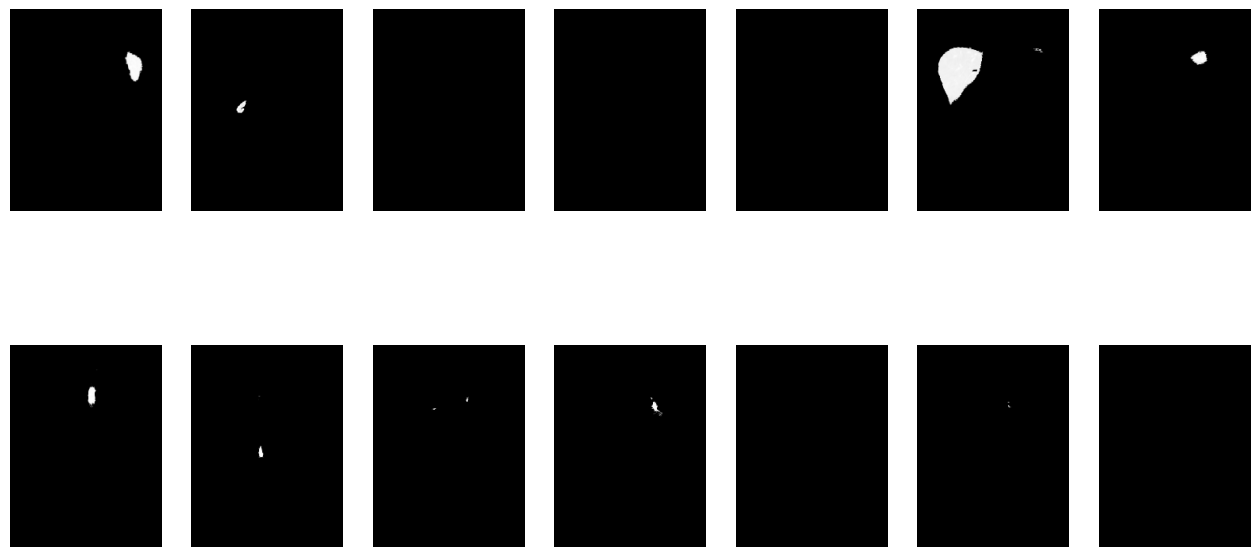

In [21]:
depth = 80

fig, ax = plt.subplots(ncols=7, nrows=2, figsize=(16, 8))
ax[0, 0].imshow(each_org_transformation[0][depth], cmap='gray')
ax[0, 0].axis('off')
ax[0, 1].imshow(each_org_transformation[1][depth], cmap='gray')
ax[0, 1].axis('off')
ax[0, 2].imshow(each_org_transformation[2][depth], cmap='gray')
ax[0, 2].axis('off')
ax[0, 3].imshow(each_org_transformation[3][depth], cmap='gray')
ax[0, 3].axis('off')
ax[0, 4].imshow(each_org_transformation[4][depth], cmap='gray')
ax[0, 4].axis('off')
ax[0, 5].imshow(each_org_transformation[5][depth], cmap='gray')
ax[0, 5].axis('off')
ax[0, 6].imshow(each_org_transformation[6][depth], cmap='gray')
ax[0, 6].axis('off')
ax[1, 0].imshow(each_org_transformation[7][depth], cmap='gray')
ax[1, 0].axis('off')
ax[1, 1].imshow(each_org_transformation[8][depth], cmap='gray')
ax[1, 1].axis('off')
ax[1, 2].imshow(each_org_transformation[9][depth], cmap='gray')
ax[1, 2].axis('off')
ax[1, 3].imshow(each_org_transformation[10][depth], cmap='gray')
ax[1, 3].axis('off')
ax[1, 4].imshow(each_org_transformation[11][depth], cmap='gray')
ax[1, 4].axis('off')
ax[1, 5].imshow(each_org_transformation[12][depth], cmap='gray')
ax[1, 5].axis('off')
ax[1, 6].imshow(np.zeros_like(each_org_transformation[12][depth]), cmap='gray')
ax[1, 6].axis('off')



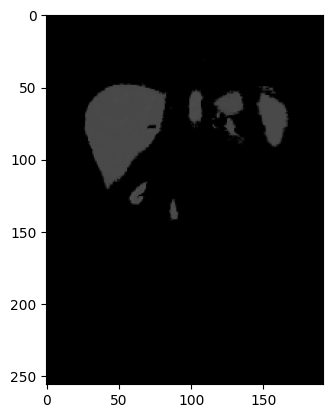

In [22]:
combination = np.maximum.reduce(each_org_transformation)

plt.imshow(combination[depth], cmap='gray', vmin=0, vmax=1)

In [23]:
def predict_organs(input):
    each_org_transformation = []

    for organ in tqdm(legend_labels):
        fixed_input = np.zeros_like(input[0])
        fixed_input[input[1] == organ] = input[0][input[1] == organ]
        moving_input = np.zeros_like(input[2])
        moving_input[input[3] == organ] = input[2][input[3] == organ]
    
        if organ == 1:
            test_pred = tuple(spleen_model.predict((fixed_input, moving_input),verbose=0))
        elif organ == 2:
            test_pred = tuple(rkidney_model.predict((fixed_input, moving_input),verbose=0))
        elif organ == 3:
            test_pred = tuple(lkidney_model.predict((fixed_input, moving_input),verbose=0))
        elif organ == 4:
            test_pred = tuple(gbladder_model.predict((fixed_input, moving_input),verbose=0))
        elif organ == 5:
            test_pred = tuple(esophagus_model.predict((fixed_input, moving_input),verbose=0))
        elif organ == 6:
            test_pred = tuple(liver_model.predict((fixed_input, moving_input),verbose=0))
        elif organ == 7:
            test_pred = tuple(stomach_model.predict((fixed_input, moving_input),verbose=0))
        elif organ == 8:
            test_pred = tuple(aorta_model.predict((fixed_input, moving_input),verbose=0))
        elif organ == 9:
            test_pred = tuple(ivc_model.predict((fixed_input, moving_input),verbose=0))
        elif organ == 10:
            test_pred = tuple(pandsvein_model.predict((fixed_input, moving_input),verbose=0))
        elif organ == 11:
            test_pred = tuple(pancreas_model.predict((fixed_input, moving_input),verbose=0))
        elif organ == 12:
            test_pred = tuple(ladrenalgland_model.predict((fixed_input, moving_input),verbose=0))
        else:
            test_pred = tuple(radrenalgland_model.predict((fixed_input, moving_input),verbose=0))

        each_org_transformation.append(test_pred[0][0])

    combination = np.maximum.reduce(each_org_transformation)

    return np.squeeze(combination, -1)

100%|██████████| 13/13 [00:31<00:00,  2.41s/it]


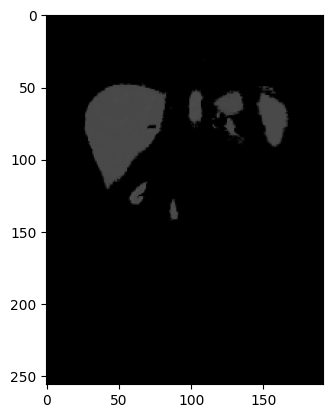

In [24]:
combination = predict_organs(test_input)

plt.imshow(combination[depth], cmap='gray', vmin=0, vmax=1)

In [25]:
combination.shape

(160, 256, 192)

# Evaluation

In [26]:
def dice_score_tf(y_true, y_pred, smooth=1e-6):
    binary_y_true = tf.cast(y_true > 0, tf.float32)
    binary_y_pred = tf.cast(y_pred > 0, tf.float32)

    y_true_flat = tf.reshape(binary_y_true, [-1])
    y_pred_flat = tf.reshape(binary_y_pred, [-1])

    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat)

    dice = (2. * intersection + smooth) / (union + smooth)
    return float(dice)

In [27]:
test_organs = np.zeros_like(test_images)
test_organs[test_labels > 0] = test_images[test_labels > 0]

In [28]:
n = test_organs.shape[0]
count = 0
dice = 0
mse = 0

for i in range(n):
    for j in range(n):
        if i == j:
            continue
        else:
            count += 1
            print(f"Step {count}/{n*n-n}:")
            combined_prediction = predict_organs((test_images[[i], ..., np.newaxis], test_labels[[i], ..., np.newaxis], test_images[[j], ..., np.newaxis], test_labels[[j], ..., np.newaxis]))
            dice += dice_score_tf(test_organs[j], combined_prediction)
            mse += np.mean(np.square(test_organs[j] - combined_prediction))
            
            print("- Current DICE: " + str(dice / count))
            print("- Current MSE: " + str(mse / count))

Step 1/30:


100%|██████████| 13/13 [00:30<00:00,  2.37s/it]


- Current DICE: 0.7550201416015625
- Current MSE: 0.0012642761912008496
Step 2/30:


100%|██████████| 13/13 [00:30<00:00,  2.32s/it]


- Current DICE: 0.7618705034255981
- Current MSE: 0.0015145316866781555
Step 3/30:


100%|██████████| 13/13 [00:33<00:00,  2.61s/it]


- Current DICE: 0.671040932337443
- Current MSE: 0.0020487628081991226
Step 4/30:


100%|██████████| 13/13 [00:31<00:00,  2.42s/it]


- Current DICE: 0.6802393645048141
- Current MSE: 0.0019638042688240676
Step 5/30:


100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


- Current DICE: 0.6921253085136414
- Current MSE: 0.0019524423849915464
Step 6/30:


100%|██████████| 13/13 [00:29<00:00,  2.28s/it]


- Current DICE: 0.6905691822369894
- Current MSE: 0.0019738034861746297
Step 7/30:


100%|██████████| 13/13 [00:31<00:00,  2.42s/it]


- Current DICE: 0.7085156696183341
- Current MSE: 0.0019035704303139197
Step 8/30:


100%|██████████| 13/13 [00:29<00:00,  2.29s/it]


- Current DICE: 0.7052414640784264
- Current MSE: 0.0019344026625634113
Step 9/30:


100%|██████████| 13/13 [00:32<00:00,  2.47s/it]


- Current DICE: 0.7131319112247891
- Current MSE: 0.0018705732966247698
Step 10/30:


100%|██████████| 13/13 [00:28<00:00,  2.22s/it]


- Current DICE: 0.7251788258552552
- Current MSE: 0.001809132794558221
Step 11/30:


100%|██████████| 13/13 [00:29<00:00,  2.30s/it]


- Current DICE: 0.7259446599266746
- Current MSE: 0.0018094216735943418
Step 12/30:


100%|██████████| 13/13 [00:30<00:00,  2.36s/it]


- Current DICE: 0.7347049613793691
- Current MSE: 0.0017331719648121418
Step 13/30:


100%|██████████| 13/13 [00:32<00:00,  2.48s/it]


- Current DICE: 0.734033790918497
- Current MSE: 0.0017475900608448953
Step 14/30:


100%|██████████| 13/13 [00:31<00:00,  2.44s/it]


- Current DICE: 0.7436420576913017
- Current MSE: 0.0016794929234996766
Step 15/30:


100%|██████████| 13/13 [00:29<00:00,  2.28s/it]


- Current DICE: 0.7513658881187439
- Current MSE: 0.001632792365820321
Step 16/30:


100%|██████████| 13/13 [00:29<00:00,  2.30s/it]


- Current DICE: 0.7331932596862316
- Current MSE: 0.001732546351390211
Step 17/30:


100%|██████████| 13/13 [00:29<00:00,  2.28s/it]


- Current DICE: 0.7308787352898541
- Current MSE: 0.0017246744910912205
Step 18/30:


100%|██████████| 13/13 [00:33<00:00,  2.55s/it]


- Current DICE: 0.7270892096890343
- Current MSE: 0.0017621184842881452
Step 19/30:


100%|██████████| 13/13 [00:33<00:00,  2.55s/it]


- Current DICE: 0.7264309901940195
- Current MSE: 0.0017571438700690425
Step 20/30:


100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


- Current DICE: 0.7302896320819855
- Current MSE: 0.0017329556422869912
Step 21/30:


100%|██████████| 13/13 [00:32<00:00,  2.49s/it]


- Current DICE: 0.7280824525015694
- Current MSE: 0.0017502499994730375
Step 22/30:


100%|██████████| 13/13 [00:31<00:00,  2.39s/it]


- Current DICE: 0.7314494496042078
- Current MSE: 0.0017189016536152844
Step 23/30:


100%|██████████| 13/13 [00:29<00:00,  2.29s/it]


- Current DICE: 0.7376485233721526
- Current MSE: 0.001685541542722715
Step 24/30:


100%|██████████| 13/13 [00:29<00:00,  2.30s/it]


- Current DICE: 0.73850134263436
- Current MSE: 0.001684657434222348
Step 25/30:


100%|██████████| 13/13 [00:33<00:00,  2.61s/it]


- Current DICE: 0.7428633165359497
- Current MSE: 0.0016605572724948802
Step 26/30:


100%|██████████| 13/13 [00:34<00:00,  2.62s/it]


- Current DICE: 0.7420223790865678
- Current MSE: 0.0016688259254268268
Step 27/30:


100%|██████████| 13/13 [00:29<00:00,  2.28s/it]


- Current DICE: 0.7460401433485525
- Current MSE: 0.0016357197741677526
Step 28/30:


100%|██████████| 13/13 [00:29<00:00,  2.25s/it]


- Current DICE: 0.7491197053875241
- Current MSE: 0.0016228581152368654
Step 29/30:


100%|██████████| 13/13 [00:30<00:00,  2.34s/it]


- Current DICE: 0.7517259737540936
- Current MSE: 0.0016104117212720744
Step 30/30:


100%|██████████| 13/13 [00:35<00:00,  2.69s/it]


- Current DICE: 0.7544242997964223
- Current MSE: 0.001590063323412542


In [29]:
print("Final DICE: " + str(dice / count))
print("Final MSE: " + str(mse / count))

Final DICE: 0.7544242997964223
Final MSE: 0.001590063323412542
